In [9]:
import sys
import numpy.core.numeric as core_numeric
import types

# Create a dummy module named "numpy._core.numeric"
shim = types.ModuleType("numpy._core.numeric")
shim.__dict__.update(core_numeric.__dict__)
sys.modules["numpy._core.numeric"] = shim

import pickle
with open('processed_data_v1.pkl', 'rb') as f:
    df = pickle.load(f)

/tmp/dcs-tmp.u2164966/ipykernel_73010/1179451061.py:12: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  df = pickle.load(f)


In [2]:
df.columns

Index(['incident_count', 'date_created', 'hour_created', 'max_final_priority',
       'inc_resourced', 'scrs_crime_inc', 'multi_member_ward', 'datazone',
       'dzone_code', 'service_code_description'],
      dtype='object')

## Clustering 

In [8]:
pip install --no-user pandas numpy gower umap-learn scikit-learn scikit-learn-extra matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 90.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.2
    Uninstalling numpy-2.3.2:
      Successfully uninstalled numpy-2.3.2
  You can safely remove it manually.
Note: you may need to restart the kernel to use updated packages.


In [10]:
# Simplifying the data: drop incident_count, datazone, and multi_member_ward
df = df.drop(['incident_count', 'datazone', 'dzone_code'], axis=1)

# Check your resulting columns
print(df.columns)

Index(['date_created', 'hour_created', 'max_final_priority', 'inc_resourced',
       'scrs_crime_inc', 'multi_member_ward', 'service_code_description'],
      dtype='object')


In [11]:
# Feature Engineering 
bool_cols = ['inc_resourced', 'scrs_crime_inc']
df[bool_cols] = df[bool_cols].astype(int)
df[bool_cols].head()

,inc_resourced,scrs_crime_inc
0,0,0
1,1,0
2,0,1
3,1,0
4,1,0


In [ ]:
# pull useful calendar parts; drop raw timestamp afterwards
df['weekday'] = df['date_created'].dt.day_of_week
df['month'] = df['date_created'].dt.month

# Checking if the range of the new columns are as intented
print(df['weekday'].max())
print(df['weekday'].min())

print(df['month'].max())
print(df['month'].min())

# keep year safely  ➜ treat as categorical proportions
df["year"] = df["date_created"].dt.year.astype("category")

df = df.drop(columns=["date_created"])                   # raw timestamp no longer needed

6
0
12
1


In [18]:
!pip uninstall -y numpy scikit-learn scikit-learn-extra umap-learn
!pip install --no-user numpy==1.24.3  # This is a stable version that works well with most packages
!pip install --no-user scikit-learn==1.3.0
!pip install --no-user scikit-learn-extra
!pip install --no-user umap-learn

Found existing installation: numpy 1.26.0
Uninstalling numpy-1.26.0:
  Successfully uninstalled numpy-1.26.0
Found existing installation: scikit-learn 1.7.1
Uninstalling scikit-learn-1.7.1:
  Successfully uninstalled scikit-learn-1.7.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 35.8 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rdt 1.18.0 requires scikit-learn>=1.1.3; python_version >= "3.11" and python_version < "3.12", which is not installed.
sdmetrics 0.23.0 requires scikit-learn>=1.1.3; python_version >= "3.11" and python_version < "3.12", which is not installed.
scipy 1.16.1 requires numpy<2.6,>=1.25.2, but you have numpy 1.24.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 65.5 MB/s eta 0:00:0000:0100:01
  Using cached numpy-2.3.2-cp311-cp311-manylinux_2_27_x86_64.manylinux_2

### Code

In [ ]:
# 0 | IMPORTS & CONFIG
import pandas as pd, numpy as np
import gower                                   # pip install gower
from sklearn_extra.cluster import KMedoids     # pip install scikit-learn-extra
from sklearn.metrics import silhouette_score
import umap, matplotlib.pyplot as plt


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.12/site-packages/ipykernel/kernelapp.py

ImportError: numpy.core.multiarray failed to import (auto-generated because you didn't call 'numpy.import_array()' after cimporting numpy; use '<void>numpy._import_array' to disable if you are certain you don't need it).

In [ ]:
# 2 | DTYPE COERCION  (ensures Gower treats cols correctly)
group_col = "multi_member_ward"

num_cols  = ["hour_created", "inc_resourced", "scrs_crime_inc"]   # numeric / binary
cat_cols  = ["max_final_priority", "service_code_description",
             "weekday", "month", "year"]                          # categoricals

for c in cat_cols + [group_col]:
    df[c] = df[c].astype("category")
df[num_cols] = df[num_cols].astype(float)

In [8]:
df.dtypes

hour_created                 float64
max_final_priority          category
inc_resourced                float64
scrs_crime_inc               float64
multi_member_ward           category
service_code_description    category
weekday                     category
month                       category
year                        category
dtype: object

In [ ]:
# 3 | COLLAPSE RARE SERVICE CODES  (< 1 % freq)
#     keeps the dummy block compact & distances stable

# 1. Add the new category
df["service_code_description"] = (
    df["service_code_description"]
      .cat.add_categories("OTHER")
)

# 2. Compute rare codes
svc_freq = df["service_code_description"].value_counts(normalize=True)
rare = svc_freq[svc_freq < 0.01].index

# 3. Collapse them into your new category
df["service_code_description"] = (
    df["service_code_description"]
      .where(~df["service_code_description"].isin(rare), "OTHER")
)

# 4. Remove unused categories
df["service_code_description"] = (
    df["service_code_description"]
      .cat.remove_unused_categories()
)

In [10]:
rare = svc_freq[svc_freq < 0.01].index
len(rare)

66

In [11]:
df["service_code_description"].value_counts(normalize=True)

service_code_description
ASSIST MEMBER OF THE PUBLIC    0.127259
OTHER                          0.105173
CONCERN FOR PERSON             0.091709
DISTURBANCE                    0.065630
THEFT                          0.064082
DOMESTIC INCIDENT              0.058400
ROAD TRAFFIC MATTER            0.057706
PUBLIC NUISANCE                0.046170
ROAD TRAFFIC COLLISION         0.044181
EXTERNAL AGENCY REQUEST        0.030042
ABANDONED/SILENT 999 CALL      0.029759
NOISE                          0.029035
ASSAULT                        0.028440
DAMAGE                         0.024753
FALSE CALL                     0.022908
NEIGHBOUR DISPUTE              0.022607
COMMUNICATIONS                 0.021814
MISSING PERSON/ABSCONDER       0.019840
SUSPECT PERSONS                0.019092
POLICE INFORMATION             0.015433
FRAUD INCIDENT                 0.014908
ROAD TRAFFIC OFFENCE           0.013831
DRUGS/SUBSTANCE MISUSE         0.012728
CHILD PROTECTION               0.012382
DOMESTIC BAIL C

In [ ]:
# 4 | ONE-HOT + GROUPBY → WARD-LEVEL PROTOTYPES
#     mean(dummy)=proportion  → everything now lies in [0,1]

df_dum  = pd.get_dummies(df[cat_cols], prefix_sep="=")
proto_in = pd.concat([df[[group_col] + num_cols], df_dum], axis=1)

proto = (
    proto_in 
      .groupby(group_col, sort=False)
      .mean()
      .assign(row_count = df.groupby(group_col).size())
)


print(f"{proto.shape[0]} wards  ×  {proto.shape[1]} columns after aggregation")

/tmp/dcs-tmp.u2164966/ipykernel_1567158/4176073297.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proto_in


354 wards  ×  56 columns after aggregation


/tmp/dcs-tmp.u2164966/ipykernel_1567158/4176073297.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .assign(row_count = df.groupby(group_col).size())


In [13]:
proto.head()

,hour_created,inc_resourced,scrs_crime_inc,max_final_priority=IMMEDIATE,max_final_priority=PROMPT,max_final_priority=STANDARD,service_code_description=ABANDONED/SILENT 999 CALL,service_code_description=ASSAULT,service_code_description=ASSIST MEMBER OF THE PUBLIC,service_code_description=CHILD PROTECTION,...,month=8,month=9,month=10,month=11,month=12,year=2022,year=2023,year=2024,year=2025,row_count
multi_member_ward,,,,,,,,,,,,,,,,,,,,,
Dennistoun,13.309714,0.844869,0.264650,0.233185,0.602354,0.164461,0.016891,0.023965,0.135923,0.005427,...,0.087322,0.087078,0.085676,0.085249,0.080798,0.256235,0.341301,0.324105,0.078358,16399
Lochee,13.774515,0.786706,0.261429,0.182720,0.607663,0.209617,0.047409,0.024624,0.116975,0.012772,...,0.089110,0.076532,0.080015,0.081080,0.083692,0.259542,0.332446,0.332398,0.075613,20671
Leith Walk,13.409101,0.745623,0.326377,0.162087,0.541739,0.296174,0.033391,0.028058,0.102551,0.008116,...,0.092928,0.081623,0.090435,0.078319,0.080696,0.246029,0.323130,0.341275,0.089565,17250
Almond,13.373668,0.795403,0.201733,0.123345,0.718727,0.157928,0.032627,0.013658,0.097530,0.009362,...,0.095714,0.088762,0.083383,0.078283,0.076327,0.239354,0.337618,0.346561,0.076466,28627
Paisley North West,13.370626,0.859781,0.221977,0.183640,0.707278,0.109082,0.014954,0.020080,0.141151,0.006693,...,0.086631,0.087901,0.082479,0.077692,0.075913,0.245616,0.333432,0.347454,0.073498,23606


In [ ]:
# 5 | GOWER DISTANCE  (block-weight service dummies)

svc_idx = proto.columns.str.startswith("service_code_description=")
weights = np.ones(proto.shape[1])
weights[svc_idx] = 1.0 / svc_idx.sum()           # whole service block → weight 1

n_true = svc_idx.sum()
print(n_true)

26


In [15]:
weights # the value of service columns is 1/26

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.03846154, 0.03846154, 0.03846154, 0.03846154,
       0.03846154, 0.03846154, 0.03846154, 0.03846154, 0.03846154,
       0.03846154, 0.03846154, 0.03846154, 0.03846154, 0.03846154,
       0.03846154, 0.03846154, 0.03846154, 0.03846154, 0.03846154,
       0.03846154, 0.03846154, 0.03846154, 0.03846154, 0.03846154,
       0.03846154, 0.03846154, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

In [16]:
D = gower.gower_matrix(proto, weight=weights)    # 354×354 matrix here
D.shape

(354, 354)

In [17]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
print(D)

[[0.         0.08555238 0.12159001 0.11414234 0.09320863 0.09878493
  0.09063879 0.10513037 0.10480841 0.11344298 0.12211762 0.09934302
  0.13676287 0.13840881 0.11848053 0.0941085  0.07353045 0.09341922
  0.11463226 0.20696776 0.18501033 0.16557646 0.06979726 0.12214831
  0.09157045 0.13113742 0.08894237 0.09624027 0.12097233 0.10629266
  0.1068324  0.10793141 0.09089199 0.10592256 0.09904519 0.09743594
  0.13643014 0.12235516 0.12121889 0.08264796 0.07828876 0.1281555
  0.11222782 0.0983443  0.08442593 0.09659485 0.13656092 0.0886839
  0.10507992 0.05857646 0.0736809  0.12085781 0.11027633 0.08470437
  0.10705484 0.14117368 0.10220464 0.08734235 0.19837467 0.12021827
  0.14209807 0.18496515 0.13143586 0.10254893 0.12845898 0.12163674
  0.08761062 0.09954538 0.09322437 0.09982596 0.10155752 0.12514123
  0.10204171 0.12293355 0.07171375 0.11131936 0.07816853 0.1614663
  0.10024939 0.06634654 0.08139898 0.13907212 0.08945431 0.10930688
  0.09149952 0.10122219 0.08463869 0.06899407 0.095

In [ ]:
# 6 | SELECT k BY SILHOUETTE  +  FIT k-MEDOIDS (FastPAM impl.)

best_k, best_score, best_model = None, -1, None
for k in range(2, min(15, len(proto))):
    km  = KMedoids(n_clusters=k, metric="precomputed",
                   init="k-medoids++", method="pam").fit(D)
    sil = silhouette_score(D, km.labels_, metric="precomputed")
    if sil > best_score:
        best_k, best_score, best_model = k, sil, km

proto["cluster"] = best_model.labels_
print(f"✔  k={best_k}  (silhouette={best_score:0.3f})")

✔  k=2  (silhouette=0.303)


In [19]:
# 1. Convert your NumPy array to a DataFrame
proto_df = pd.DataFrame(proto)

# 2. Save it to 'wards.csv' in the current working directory
proto_df.to_csv('proto.csv', index=True)

/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.9/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/dcs/large/u2164966/MSc_Dissertation/myenv/lib64/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


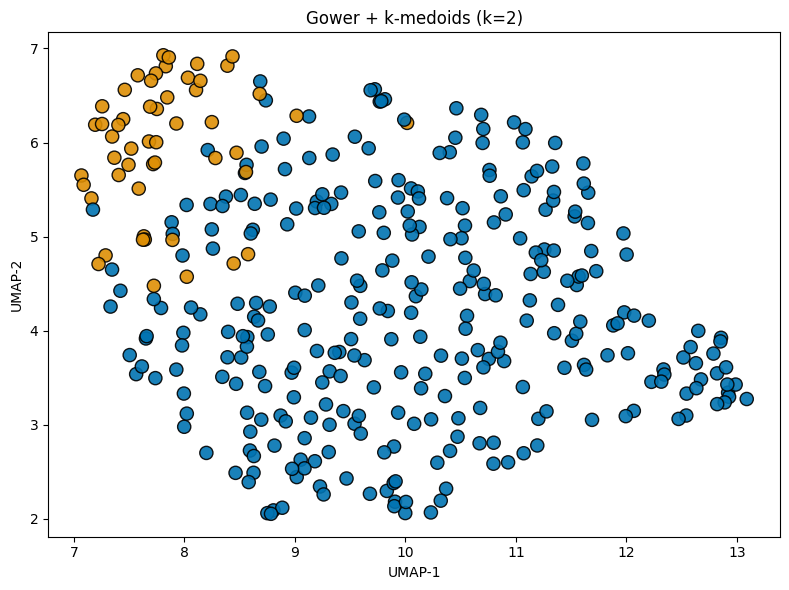

In [ ]:
# 7 | 2-D VISUALISATION  (UMAP on the Gower matrix)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns  # for palettes

# choose a high-contrast palette
palette = sns.color_palette("colorblind", n_colors=proto["cluster"].nunique())
cmap = ListedColormap(palette)

# fit UMAP embedding (unchanged)
emb = umap.UMAP(metric="precomputed", random_state=42).fit_transform(D)

# plot
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(
    emb[:, 0], emb[:, 1],
    c=proto["cluster"],
    cmap=cmap,
    s=90, edgecolor="k", alpha=0.9
)

ax.set(
    title=f"Gower + k-medoids (k={best_k})",
    xlabel="UMAP-1", ylabel="UMAP-2"
)
plt.tight_layout()
plt.show()


In [ ]:
# 8 |  EXPLORE AND NAME THE k-MEDOIDS CLUSTERS
import numpy as np
from tabulate import tabulate                     # pip install tabulate

# 1. fetch medoid indices straight from the fitted model  (sklearn-extra doc)
medoid_idx_in_proto = best_model.medoid_indices_   # central ward of each cluster

overall_mean = proto.drop(columns=["cluster", "row_count"]).mean()

rows_for_print = []
for cl, medoid_pos in enumerate(medoid_idx_in_proto):
    # mask for this cluster
    members = proto.index[proto.cluster == cl]
    # medoid ward name
    medoid  = proto.index[medoid_pos]

    # most distinctive features (absolute diff vs. overall)
    centroid = proto.loc[members].drop(columns=["cluster", "row_count"]).mean()
    diffs    = (centroid - overall_mean).abs().sort_values(ascending=False).head(5)

    rows_for_print.append([
        cl,
        medoid,
        len(members),
        ", ".join(members[:10]) + (" …" if len(members) > 10 else ""),
        "; ".join([f"{col.split('=')[0]}↑{val:.2f}" for col,val in diffs.items()])
    ])

print(tabulate(rows_for_print,
               headers=["Cluster", "Medoid ward", "Size",
                        "Ward members (truncated)",
                        "Top 5 feature deviations"]))


  Cluster  Medoid ward                       Size  Ward members (truncated)                                                                                                                                                                                       Top 5 feature deviations
---------  ------------------------------  ------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------  -----------------------------------------------------------------------------------------------------------------------------------
        0  Tillydrone/Seaton/Old Aberdeen     302  Dennistoun, Lochee, Leith Walk, Craigentinny/Duddingston, Torry/Ferryhill, Tranent, Wallyford and Macmerry, Troon, Trossachs and Teith, Turriff and District, Tweeddale East …                                 max_final_priority↑0.02; max_final_priority↑0.02; scrs_crime_inc↑0.01

✅ All ward polygons are now matched to clusters.


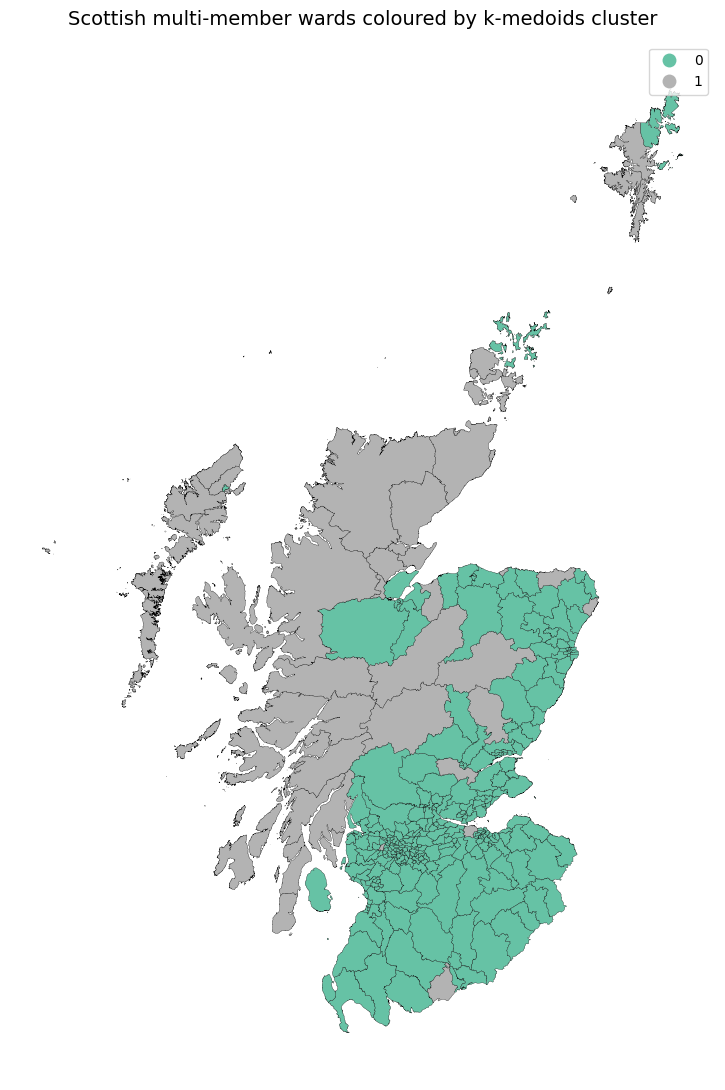

In [ ]:
# 0 | Imports & helper

import re
import pandas as pd
import geopandas as gpd
import shapely.wkt
import matplotlib.pyplot as plt
from rapidfuzz import process, fuzz

def clean(name: str) -> str:
    """Normalise a ward name for robust fuzzy matching."""
    name = (
        name.lower()
            .replace("&", "and")
            .replace("/", " ")
            .replace(",", " ")
            .replace("'", "")
            .replace("ward", " ")
    )
    name = re.sub(r"[^\w\s]", " ", name)    # drop punctuation
    return re.sub(r"\s+", " ", name).strip()

# 1 | Load ward polygons (CSV you uploaded)  ➜  GeoDataFrame
CSV_PATH = "wards.csv"          # adjust if needed
raw = pd.read_csv(CSV_PATH)

wards = gpd.GeoDataFrame(
    raw.drop(columns="geometry"),
    geometry=gpd.GeoSeries.from_wkt(raw["geometry"]),
    crs="EPSG:4326",
)
wards["name_clean"] = wards["multi_member_ward"].apply(clean)

# 2 | Bring in your k-medoids table (assumes `proto` is in RAM)
ward_clusters = (
    proto["cluster"]                       # proto from your earlier script
         .rename_axis("proto_name")
         .reset_index()                    # proto_name, cluster
         .assign(proto_clean=lambda d: d["proto_name"].apply(clean))
)

# 3 | First fuzzy-match pass  (threshold 80)
def best_proto(name_raw: str, name_clean: str, min_score):
    match, score, _ = process.extractOne(
        name_clean,
        ward_clusters["proto_clean"],
        scorer=fuzz.token_set_ratio,
    )
    if score >= min_score:
        return ward_clusters.loc[
            ward_clusters["proto_clean"] == match, "proto_name"
        ].iat[0]

    match, score, _ = process.extractOne(
        name_raw,
        ward_clusters["proto_name"],
        scorer=fuzz.token_set_ratio,
    )
    return match if score >= min_score else None

MIN_SCORE_1 = 80
lookup = {
    row.multi_member_ward: best_proto(row.multi_member_ward, row.name_clean, MIN_SCORE_1)
    for row in wards.itertuples()
}

# 4 | Second-pass rescue  – ONLY for names still unmatched
#       → use the *same CSV* names but drop the threshold to 60
MIN_SCORE_2 = 60
still_unmatched = [w for w, m in lookup.items() if m is None]

for name in still_unmatched:
    row = wards.loc[wards["multi_member_ward"] == name].iloc[0]
    lookup[name] = best_proto(row.multi_member_ward, row.name_clean, MIN_SCORE_2)

# 5 | Merge polygons ←→ clusters
gdf = (
    wards
      .assign(proto_name=lambda d: d["multi_member_ward"].map(lookup))
      .merge(
          ward_clusters[["proto_name", "cluster"]],
          on="proto_name",
          how="left",
      )
      .drop(columns=["name_clean", "proto_name"])
)

# 6 | Final check
leftover = gdf[gdf["cluster"].isna()]["multi_member_ward"]
if leftover.empty:
    print("✅ All ward polygons are now matched to clusters.")
else:
    print(
        f"⚠️  {len(leftover)} ward polygons still have no cluster label "
        "(shown grey on the map):\n  - "
        + "\n  - ".join(leftover.tolist())
    )

# 7 | Plot
fig, ax = plt.subplots(figsize=(9, 11))
gdf.plot(
    column="cluster",
    cmap="Set2",
    categorical=True,
    linewidth=0.2,
    edgecolor="black",
    legend=True,
    ax=ax,
)

ax.set_title(
    "Scottish multi-member wards coloured by k-medoids cluster",
    fontsize=14,
    pad=12,
)
ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Helper: get fuzzy match score for each mapping
def get_proto_match_info(row, min_score=80):
    name_raw, name_clean = row['multi_member_ward'], row['name_clean']
    # First pass: cleaned names
    match, score, _ = process.extractOne(
        name_clean,
        ward_clusters["proto_clean"],
        scorer=fuzz.token_set_ratio,
    )
    if score >= min_score:
        proto_name = ward_clusters.loc[ward_clusters["proto_clean"] == match, "proto_name"].iat[0]
        cluster = ward_clusters.loc[ward_clusters["proto_clean"] == match, "cluster"].iat[0]
        return pd.Series([proto_name, cluster, score])
    # Second pass: raw names, lower threshold
    match, score, _ = process.extractOne(
        name_raw,
        ward_clusters["proto_name"],
        scorer=fuzz.token_set_ratio,
    )
    if score >= min_score:
        cluster = ward_clusters.loc[ward_clusters["proto_name"] == match, "cluster"].iat[0]
        return pd.Series([match, cluster, score])
    return pd.Series([None, None, score])

# Build a DataFrame to inspect
inspect_df = (
    wards
    .copy()
    .assign(
        proto_name=lambda d: d["multi_member_ward"].map(lookup),
    )
    .merge(
        ward_clusters[["proto_name", "cluster"]],
        on="proto_name",
        how="left"
    )
)

# Add scores for each mapping
inspect_df[["matched_proto", "matched_cluster", "match_score"]] = wards.apply(get_proto_match_info, axis=1)

# Choose columns to display
display_cols = [
    "multi_member_ward", "name_clean", "matched_proto", "matched_cluster", "match_score"
]
print(inspect_df[display_cols].to_string(index=False))


                                    multi_member_ward                                          name_clean                                        matched_proto  matched_cluster  match_score
                                    Torry / Ferryhill                                     torry ferryhill                                      Torry/Ferryhill              0.0   100.000000
                         Dyce / Bucksburn / Danestone                            dyce bucksburn danestone                             Dyce/Bucksburn/Danestone              0.0   100.000000
                                        Lower Deeside                                       lower deeside                                        Lower Deeside              0.0   100.000000
                    Hazlehead / Ashley / Queens Cross                       hazlehead ashley queens cross                 Hazlehead/Queens Cross/Countesswells              0.0    86.274510
                            Kingswells / Sheddocksley  

✔  k=2  via hierarchical clustering  (silhouette=0.639)


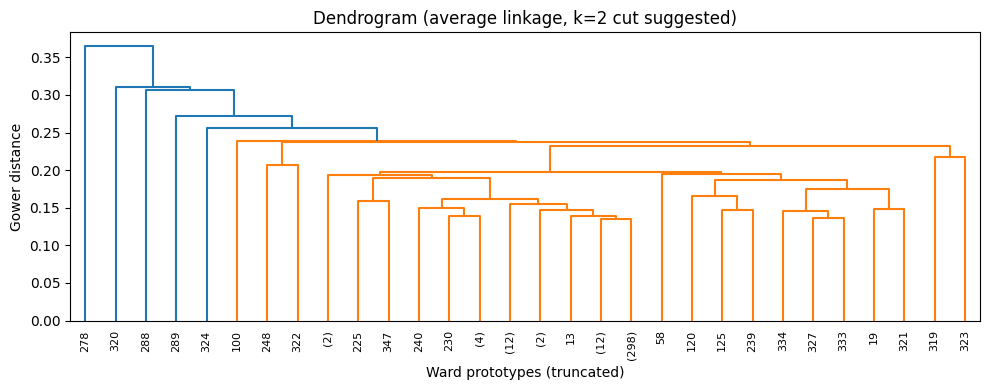

In [ ]:
# 6′ |  HIERARCHICAL (AGGLOMERATIVE) CLUSTERING  ────────────────
#     – uses the same Gower matrix D, so no re-computing!
#     – 'average' linkage because it plays well with any metric
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram
import scipy.spatial.distance as ssd

# (a) pick k by silhouette, exactly as before
best_k, best_score, best_labels = None, -1, None
for k in range(2, min(15, len(proto))):
    hac = AgglomerativeClustering(
              n_clusters=k,
              metric="precomputed",         # tells sklearn we pass a distance matrix
              linkage="average"             # Ward needs Euclidean, so use average
          ).fit(D)
    sil = silhouette_score(D, hac.labels_, metric="precomputed")
    if sil > best_score:
        best_k, best_score, best_labels = k, sil, hac.labels_

proto["cluster"] = best_labels
print(f"✔  k={best_k}  via hierarchical clustering  (silhouette={best_score:0.3f})")

# (b) quick dendrogram for interpretability  (optional visual)
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

# scipy linkage needs a condensed 1-D vector
condensed = ssd.squareform(D, checks=False)
Z = linkage(condensed, method="average")

plt.figure(figsize=(10, 4))
dendrogram(
    Z,
    truncate_mode="lastp",   # show top‐level structure only
    p=30,                    # show last 30 merged clusters
    leaf_rotation=90,
    leaf_font_size=8,
    color_threshold=None
)
plt.title(f"Dendrogram (average linkage, k={best_k} cut suggested)")
plt.xlabel("Ward prototypes (truncated)")
plt.ylabel("Gower distance")
plt.tight_layout()
plt.show()